In [ ]:
import os
import shutil
import tensorflow as tf
import random
import cv2
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import roc_curve
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

seed = 1
random.seed(seed)
directory = "/content/drive/MyDrive/trainData/chestXray"
train_dir =  "train/"
test_dir = "test/"
val_dir = "val/"

In [ ]:
train_examples = 0
test_examples = 0
val_examples = 0

train_path = os.path.join(directory, train_dir)
test_path = os.path.join(directory, test_dir)
val_path = os.path.join(directory, val_dir)

normal_examples = 0
pneumonia_examples = 0



In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def apply_clahe(image):
    # Converte a imagem para escala de cinza
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = gray.astype(np.uint16)
    # Aplica o filtro CLAHE
    clahe = cv2.createCLAHE(clipLimit=6.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(gray)
    clahe_image_normalized = cv2.normalize(clahe_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # Converte de volta a RGB
    clahe_image_rgb = cv2.cvtColor(clahe_image_normalized, cv2.COLOR_GRAY2RGB)

    clahe_image_rgb = clahe_image_rgb.astype(np.float64)
    return clahe_image_rgb

def apply_gaussian_filter(image, kernel_size=(5, 5), sigma_x=0):
    # Aplica o filtro Gaussiano
    gaussian_image = cv2.GaussianBlur(image, kernel_size, sigma_x)

    return gaussian_image


def apply_median_filter(image, kernel_size=3):
    # Aplica o filtro de harmonização de mediana
    median_filtered_image = cv2.medianBlur(image, kernel_size)
    return median_filtered_image

def apply_mean_filter(image, kernel_size=3):
    # Aplica o filtro de harmonização da média
    mean_filtered_image = cv2.blur(image, (kernel_size, kernel_size))
    return mean_filtered_image

def apply_histogram_equalization(image):
    # Converte a imagem para escala de cinza
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = gray.astype(np.uint8)

    # Aplica o filtro de equalização do histograma
    equalized_image = cv2.equalizeHist(gray)
    he_image_normalized = cv2.normalize(equalized_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # Converte de volta para RGB
    equalized_image = cv2.cvtColor(he_image_normalized, cv2.COLOR_GRAY2RGB)
    equalized_image = equalized_image.astype(np.float64)


    return equalized_image

def apply_mean_and_histogram_equalization(image, kernel_size=7):
    # Converte a imagem para escala de cinza
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = gray.astype(np.uint8)

    # Aplica a equalização do histograma e harmonização da média (Duplo filtro)
    equalized_image = cv2.equalizeHist(gray)
    he_image_normalized = cv2.normalize(equalized_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # De volta para RGB
    equalized_image = cv2.cvtColor(he_image_normalized, cv2.COLOR_GRAY2RGB)
    equalized_image = equalized_image.astype(np.float64)
    equalized_and_mean_image = cv2.blur(equalized_image, (kernel_size, kernel_size))


    return equalized_image

def apply_median_and_gaussian(image, kernel_size = 3, sigma_x = 0):
    gaussian_kernel = (5,5)
    gaussian_image = cv2.GaussianBlur(image, gaussian_kernel, sigma_x)
    median_gaussian_image = cv2.medianBlur(gaussian_image,kernel_size)

    return median_gaussian_image

def apply_contrast_enhancement(image):
    # Converte a imagem para escala de cinza
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray_image = gray_image.astype(np.uint8)

    # Aplica o contraste de equalização(Histograma)
    enhanced_image = cv2.equalizeHist(gray_image)

    # Converte de volta para RGB
    enhanced_image_rgb = cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2RGB)

    return enhanced_image_rgb.astype(np.float64)

def apply_contrast_enhancement_and_mean_rgb(image, kernel_size=3):
    # Separa os canais RGB
    r, g, b = cv2.split(image.astype(np.uint8))

    # Aplica equalização do histograma nos canais
    r_equalized = cv2.equalizeHist(r)
    g_equalized = cv2.equalizeHist(g)
    b_equalized = cv2.equalizeHist(b)

    # Junta os canais de volta
    enhanced_image = cv2.merge((r_equalized, g_equalized, b_equalized))

    enhanced_image_meaned = cv2.blur(enhanced_image, (kernel_size, kernel_size))

    return enhanced_image_meaned.astype(np.float64)

In [ ]:
img_size = 224
datagen = ImageDataGenerator(
        zoom_range=0.1, # Usa um zoom de 10% nas imagens de forma aleatória
        width_shift_range=0.3,  # Muda as imagens horizontalmente(estica em 30%) de forma aleatória
        rescale=1.0/255.0,
        )
"""
datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        preprocessing_function=apply_mean_and_histogram_equalization,
)
"""
testDatagen = ImageDataGenerator(
    rescale = 1.0/255.0,
)

train_generator = datagen.flow_from_directory(train_path,
                                            batch_size=32,
                                            shuffle=True,
                                            class_mode='binary',
                                            target_size=(img_size, img_size),
                                            classes=['NORMAL', 'PNEUMONIA']
)

validation_generator = datagen.flow_from_directory(val_path,
                                            batch_size=32,
                                            shuffle=False,
                                            class_mode='binary',
                                            target_size=(img_size, img_size),
                                            classes=['NORMAL', 'PNEUMONIA']
)

test_generator = testDatagen.flow_from_directory(test_path,
                                            batch_size=32,
                                            shuffle=False,
                                            class_mode='binary',
                                            target_size=(img_size, img_size),
                                            classes=['NORMAL', 'PNEUMONIA']
)

class_labels = train_generator.class_indices
train_examples = train_generator.samples
val_examples = validation_generator.samples
test_examples = test_generator.samples

Found 4192 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
print(train_generator[0][0].shape)

(32, 224, 224, 3)


In [ ]:
# Mapeando o número de classes
class_indices = train_generator.class_indices

# Contando o número de exemplos de cada classe para ser usado no cálculo do peso
normal_examples = len(os.listdir(os.path.join(train_path, 'NORMAL'))) + len(os.listdir(os.path.join(val_path, 'NORMAL'))) + len(os.listdir(os.path.join(test_path, 'NORMAL')))
pneumonia_examples = len(os.listdir(os.path.join(train_path, 'PNEUMONIA'))) + len(os.listdir(os.path.join(val_path, 'PNEUMONIA'))) + len(os.listdir(os.path.join(test_path, 'PNEUMONIA')))

print(normal_examples)
print(pneumonia_examples)

1583
4273


0.01685056 0.72719765


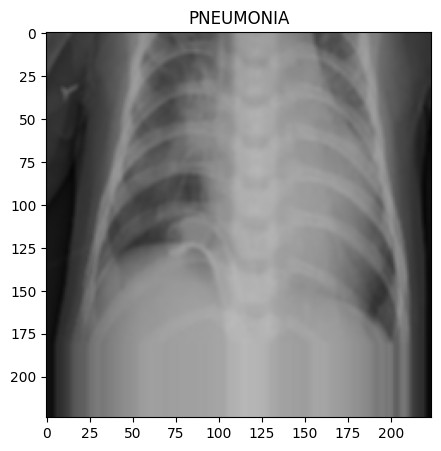

0.0 0.72719765


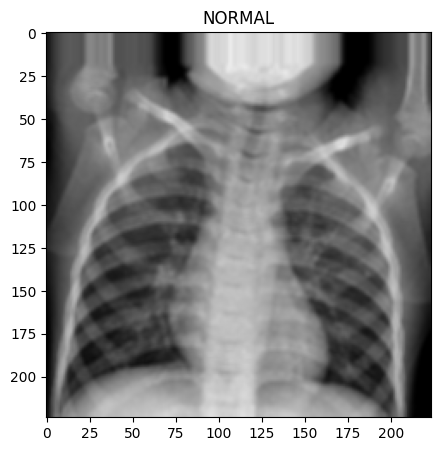

In [ ]:
import matplotlib.pyplot as plt

labels = ['NORMAL', 'PNEUMONIA']

batch = next(train_generator)
print(batch[0][0].min(), batch[0][0].max())

image = batch[0][0]
label = int(batch[1][0])

plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.title(labels[label])
plt.show()


last_batch = next(train_generator)
print(last_batch[0][0].min(), batch[0][0].max())

plt.figure(figsize=(5, 5))
plt.imshow(last_batch[0][0])
plt.title(labels[int(last_batch[1][0])])

plt.show()


In [ ]:
weight_for_0 = pneumonia_examples / (normal_examples + pneumonia_examples)
weight_for_1 = normal_examples / (normal_examples + pneumonia_examples)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.73
Weight for class 1: 0.27


In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf

base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

predictions = Dense(1, activation='sigmoid')(x)


model = Model(inputs=base_model.input, outputs=predictions)

# Compilando o modelo
model.compile(optimizer='adam', loss='binary_focal_crossentropy', metrics=['accuracy'])

# Observação do resumo do modelo
model.summary()

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

history = model.fit(
    train_generator,
    batch_size=32,
    epochs=100,
    validation_data=validation_generator,
    steps_per_epoch = (train_examples)//32,
    class_weight=class_weight,
    callbacks = [early_stopping]
)


In [ ]:
evaluation = model.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")



In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Criando arrays de predição e classes
preds = []
orig_test_labels = test_generator.classes


# Itera grupo por grupo relacionando predição com classe real
for i in range(len(test_generator)):
    batch_data, batch_labels = next(test_generator)
    batch_preds = model.predict(batch_data, batch_size=32, verbose = 0)
    for batches in batch_preds:
      if batches > 0.5:
        preds.extend([1.])
      else:
        preds.extend([0.])

# Converte para arrays numpy
preds = np.array(preds)
print(preds)
print(orig_test_labels)
# Calculando nossas métricas e demonstração visual da matriz de confusão
accuracy = accuracy_score(orig_test_labels, preds)
precision = precision_score(orig_test_labels, preds)
recall = recall_score(orig_test_labels, preds)
f1 = f1_score(orig_test_labels, preds)
conf_matrix = confusion_matrix(orig_test_labels, preds)

print(f'Acurácia: {accuracy}')
print(f'Precisão: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print('Matriz de Confusão:')
print(conf_matrix)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Salvando o modelo (ESTILO LEGADO, PODE SER FEITO DE OUTRA FORMA)
model.save('modeloXception.h5')  # Salva como um arquivo .h5

# Salva o JSON
model_json = model.to_json()
with open("modeloXception.json", "w") as json_file:
    json_file.write(model_json)

# Salve os pesos como HDF5
model.save_weights("modeloXception_weights.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
